In [1]:
# Various torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# torchvision
from torchvision import datasets, transforms

# ------------------------
# get up one directory 
import sys, os
sys.path.append(os.path.abspath('../'))
# ------------------------

# custom packages
import models.aux_funs as maf
import optimizers as op
import regularizers as reg
import train
import math
import utils.configuration as cf
import utils.datasets as ud
from models.mnist_conv import mnist_conv

# Fix the random seed

In [2]:
random_seed = 0
cf.seed_torch(random_seed)

# Configure the experiment

In [3]:
conf_args = {#
    # data specification
    'data_file':"../../datasets",'train_split':0.95, 'data_set':"Fashion-MNIST", 'download':True,
    # cuda
    'use_cuda':False, 'num_workers':0, 'cuda_device':0, 'pin_memory':True, 'train_split':0.95,
    #
    'epochs':50,
    # optimizer
    'delta':1.0, 'lr':0.001, 'lamda_0':.5, 'lamda_1':.5, 'optim':"AdaBreg", 'conv_group':True,
    'beta':0.0,
    # initialization
    'sparse_init':0.01, 'r':[10.,10.,10.],
    # misc
    'random_seed':random_seed, 'eval_acc':True,
}

conf = cf.Conf(**conf_args)

# Initiate the model

In [4]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    

model = mnist_conv(**model_kwargs)
best_model = train.best_model(mnist_conv(**model_kwargs).to(conf.device))

# Weight initialization

In [5]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    
def init_weights(conf, model):
    # sparsify
    maf.sparse_bias_uniform_(model, 0,conf.r[0])
    maf.sparse_bias_uniform_(model, 0,conf.r[0], ltype=torch.nn.Conv2d)
    maf.sparse_weight_normal_(model, conf.r[1])
    maf.sparse_weight_normal_(model, conf.r[2], ltype=torch.nn.Conv2d)
    #
    maf.sparsify_(model, conf.sparse_init, ltype = nn.Conv2d, conv_group=conf.conv_group)
    maf.sparsify_(model, conf.sparse_init, ltype = nn.Linear)
    model = model.to(conf.device)    
    return model

model = init_weights(conf,model)

# Optimizer

In [6]:
def init_opt(conf, model):
    # -----------------------------------------------------------------------------------
    # Get access to different model parameters
    # -----------------------------------------------------------------------------------
    weights_conv = maf.get_weights_conv(model)
    weights_linear = maf.get_weights_linear(model)
    biases = maf.get_bias(model)
    
    # -----------------------------------------------------------------------------------
    # Initialize optimizer
    # -----------------------------------------------------------------------------------
    if conf.conv_group:
        reg2 = reg.reg_l1_l2_conv(lamda=conf.lamda_0)
    else:
        reg2 = reg.reg_l1(lamda=conf.lamda_0)
    
    if conf.optim == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta)
    elif conf.optim == "LinBreg":
        opt = op.LinBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2, 'momentum':conf.beta,'delta':conf.delta},
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1), 'momentum':conf.beta,'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])
    elif conf.optim == "ProxSGD":
        opt = op.ProxSGD([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2, 'momentum':conf.beta,'delta':conf.delta},
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1), 'momentum':conf.beta,'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])            
    elif conf.optim == "AdaBreg":
        opt = op.AdaBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2,'delta':conf.delta},
                           {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1),'delta':conf.delta},
                           {'params': biases, 'lr': conf.lr}])
    elif conf.optim == "L1SGD":
        def weight_reg(model):
            reg1 =  reg.reg_l1(lamda=conf.lamda_1)
        
            loss1 = reg1(model.layers2[0].weight) + reg1(model.layers2[2].weight)
            loss2 = reg2(model.layers1[0].weight) + reg2(model.layers1[3].weight)
            return loss1 + loss2
        
        conf.weight_reg = weight_reg
        
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=beta)
    else:
        raise ValueError("Unknown Optimizer specified")

    # learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5,threshold=0.01)
    
    return opt, scheduler

# Dataset

In [7]:
train_loader, valid_loader, test_loader = ud.get_data_set(conf)

# History and Runs

In [8]:
# Initialize history
tracked = ['loss', 'node_sparse']
test_hist = {}
train_hist = {}
val_hist = {}
conv_sparsities = []
linear_sparsities = []

# Training

In [9]:
# -----------------------------------------------------------------------------------
# Reinit weights and the corresponding optimizer
# -----------------------------------------------------------------------------------
model = init_weights(conf, model)
opt, scheduler = init_opt(conf, model)

# -----------------------------------------------------------------------------------
# train the model
# -----------------------------------------------------------------------------------
for epoch in range(conf.epochs):
    print(25*"<>")
    print(50*"|")
    print(25*"<>")
    print('Epoch:', epoch)

    # ------------------------------------------------------------------------
    # train step, log the accuracy and loss
    # ------------------------------------------------------------------------
    train_data = train.train_step(conf, model, opt, train_loader)

    # update history
    for key in tracked:
        if key in train_data:
            var_list = train_hist.setdefault(key, [])
            var_list.append(train_data[key])           

    # ------------------------------------------------------------------------
    # validation step
    # ------------------------------------------------------------------------
    val_data = train.validation_step(conf, model, opt, valid_loader)

    # update validation history
    for key in tracked:
        if key in val_data:
            var = val_data[key]
            if isinstance(var, list):
                for i, var_loc in enumerate(var):
                    key_loc = key+"_" + str(i)
                    var_list = val_hist.setdefault(key_loc, [])
                    val_hist[key_loc].append(var_loc)
            else:
                var_list = val_hist.setdefault(key, [])
                var_list.append(var)   

    scheduler.step(train_data['loss'])
    print("Learning rate:", opt.param_groups[0]['lr'])
    best_model(train_data['acc'], val_data['acc'], model=model)
    conv_sparse = maf.conv_sparsity(model)
    linear_sparse = maf.linear_sparsity(model)
    conv_sparsities.append(conv_sparse)
    linear_sparsities.append(linear_sparse)
    print(f"Conv sparsity: {conv_sparse:.4f}, Linear sparsity: {linear_sparse:.4f}")
    
    # ------------------------------------------------------------------------
    # Test accuracy per epoch
    # ------------------------------------------------------------------------
    test_data = train.test(conf, model, test_loader)
    test_acc = test_hist.setdefault('acc', [])
    test_acc.append(test_data['acc'])
    print(f"Test accuracy: {test_data['acc']:.4f}")

<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 0
--------------------------------------------------
Train Accuracy: 0.10035087719298245
Train Loss: 1035.3100192546844
--------------------------------------------------
Validation Accuracy: 0.092
Non-zero kernels: 0.009615384615384616
Linear sparsity: 0.009829847678916828
Overall sparsity: 0.009735479285134038
Node sparsity: [1.0, 0.5]
Regularization values per group: [208.51661443710327, 231.26366138458252, 0.0]
Learning rate: 0.001
Conv sparsity: 0.0096, Linear sparsity: 0.0098
--------------------------------------------------
Test Accuracy: 0.1
Test accuracy: 0.1000
<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 1
--------------------------------------------------
Train Accuracy: 0.19026315789473683
Train Loss: 

# Evaluation

In [10]:
train.test(conf, best_model.best_model, test_loader) # this is for adabreg, as specifed in conf_args
print(f'Convolution kernel sparsity: {maf.conv_sparsity(best_model.best_model)}')
print(f'Linear sparsity: {maf.linear_sparsity(best_model.best_model)}')

--------------------------------------------------
Test Accuracy: 0.8871
Convolution kernel sparsity: 0.031490384615384615
Linear sparsity: 0.049776353965183755


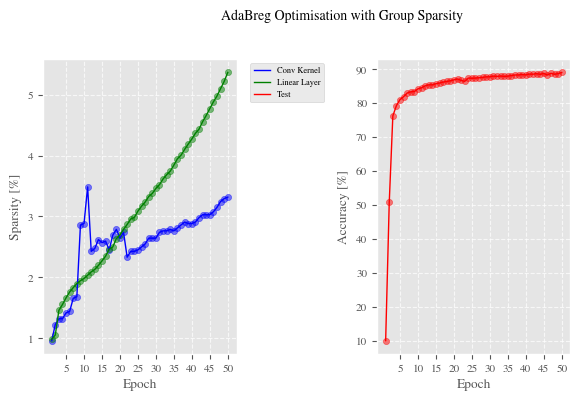

In [16]:
# Updated plotting cell with separate sparsity metrics and modified x-axis
import matplotlib
import matplotlib.pyplot as plt

# Apply nice styling
plt.style.use('default')
plt.style.use('ggplot')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 2
matplotlib.rcParams['text.color'] = 'black'

# Create a figure with 1x2 subplots
fig, ax = plt.subplots(1, 2)
ax = np.ravel(ax)  # Convert to 1D array for consistent indexing

# Create arrays for plotting
x = np.array(range(1, conf.epochs + 1))

# Plot 1: Sparsity vs Epochs - now with separate conv and linear sparsity
colors = ['blue', 'green', 'purple']

# Plot convolution kernel sparsity
ax[0].plot(x, [val * 100 for val in conv_sparsities], linestyle='-', color=colors[0], label='Conv Kernel')
ax[0].scatter(x, [val * 100 for val in conv_sparsities], color=colors[0], s=20, alpha=0.5)

# Plot linear layer sparsity 
ax[0].plot(x, [val * 100 for val in linear_sparsities], linestyle='-', color=colors[1], label='Linear Layer')
ax[0].scatter(x, [val * 100 for val in linear_sparsities], color=colors[1], s=20, alpha=0.5)

# Configure sparsity axis
ax[0].set_ylabel('Sparsity [%]')
ax[0].set_xlabel('Epoch')
ax[0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: Accuracy vs Epochs (with scatter points)
colors = ['red', 'blue', 'green']
if 'acc' in test_hist:
    test_acc = [val * 100 for val in test_hist['acc']]  # Convert to percentage
    ax[1].plot(x, test_acc, linestyle='-', color=colors[0], label='Test')
    ax[1].scatter(x, test_acc, color=colors[0], s=20, alpha=0.5)
    
if 'acc' in train_hist:
    train_acc = [val * 100 for val in train_hist['acc']]  # Convert to percentage
    ax[1].plot(x, train_acc, linestyle='-', color=colors[1], label='Training')
    ax[1].scatter(x, train_acc, color=colors[1], s=20, alpha=0.5)
    
if 'acc' in val_hist:
    val_acc = [val * 100 for val in val_hist['acc']]  # Convert to percentage
    ax[1].plot(x, val_acc, linestyle='-', color=colors[2], label='Validation')
    ax[1].scatter(x, val_acc, color=colors[2], s=20, alpha=0.5)

# Configure accuracy axis
ax[1].set_ylabel('Accuracy [%]')
ax[1].set_xlabel('Epoch')
ax[1].grid(True, linestyle='--', alpha=0.7)

# Set x-ticks to intervals of 5 epochs for both subplots
xticks = range(5, conf.epochs + 1, 5)  # Start at 5, go to max epochs, step by 5
ax[0].set_xticks(xticks)
ax[1].set_xticks(xticks)

# Get legend handles from both plots
handles = []
labels = []
for i in range(len(ax)):
    h, l = ax[i].get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Add a legend to the figure but position it outside
ax[0].legend(handles, labels, loc='upper left', bbox_to_anchor=(1.05, 1), prop={'size': 6}, ncol=1)

# Adjust size and title
width = 5.50107 / 0.8
height = 8.02778 / (2.0)
fig.set_size_inches(width, height)
fig.suptitle('AdaBreg Optimisation with Group Sparsity', fontsize=10)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.85, 0.95])

plt.show()